In [852]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import linregress
import ast

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
import scipy.stats as st
from scipy.stats import uniform, randint
from sklearn.metrics import recall_score, make_scorer, f1_score
from sklearn.decomposition import PCA



In [853]:
pd.set_option('display.max_columns', None)
#pd.reset_option('display.max_columns')

Doing the same as the previous notebook but I will add the match level features that I saved down to this csv:

'data/player_level_stats.csv'



In [854]:
matchesSpain = pd.read_csv('data/matches_Spain.csv')
matchesItaly = pd.read_csv('data/matches_Italy.csv')
matchesGermany = pd.read_csv('data/matches_Germany.csv')
matchesFrance= pd.read_csv('data/matches_France.csv')
matchesEngland = pd.read_csv('data/matches_England.csv')

matches=pd.concat((matchesEngland,matchesSpain,matchesItaly,matchesGermany,matchesFrance), axis=0)

Dropping columns not needed for this phase

In [855]:
matches.drop(['status','duration','team1.scoreET','team1.scoreP','team1.hasFormation','team2.scoreET','team2.scoreP','team2.hasFormation'],
             axis=1, inplace=True)

In [856]:
matches.drop(['roundId','seasonId'],
             axis=1, inplace=True)

In [857]:
matches.drop(['teamsData', 'venue', 
                'date', 'referees', 'team1.coachId', 
                'team1.formation', 'team1.formation.bench', 'team1.formation.lineup',
                'team1.formation.substitutions', 'team2.coachId',
                'team2.formation', 'team2.formation.bench', 'team2.formation.lineup',
                'team2.formation.substitutions'],
            axis=1, inplace=True)


Sorting by date

In [858]:
matches=matches.sort_values(by=['dateutc','wyId']).reset_index(drop=True)

Mapping teamId to teamName

In [859]:
teams=pd.read_csv('data/teams.csv')
team_mapping=teams.set_index('wyId')['name'].to_dict()

In [860]:
matches['team1.teamId']=matches['team1.teamId'].map(team_mapping)
matches['team2.teamId']=matches['team2.teamId'].map(team_mapping)
matches['winner']=matches['winner'].map(team_mapping)

matches.rename(columns={'team1.teamId':'team1.teamName','team2.teamId':'team2.teamName'}, inplace=True)

#### Restructuring matches table so that it is more easier to identify the home and away teams

In [861]:
home_teams1 = matches[matches['team1.side'] == 'home'].copy()
home_teams1 = home_teams1[['team1.teamName', 'team1.score', 'team1.scoreHT']]
home_teams1.columns=[ 'home.teamName', 'home.score', 'home.scoreHT']

home_teams2 = matches[matches['team2.side'] == 'home'].copy()
home_teams2 = home_teams2[['team2.teamName', 'team2.score', 'team2.scoreHT']]
home_teams2.columns = ['home.teamName', 'home.score', 'home.scoreHT']

home_teams=pd.concat([home_teams1, home_teams2], axis=0).sort_index()



In [862]:
away_teams1 = matches[matches['team1.side'] == 'away'].copy()
away_teams1 = away_teams1[['team1.teamName', 'team1.score', 'team1.scoreHT']]
away_teams1.columns=['away.teamName', 'away.score', 'away.scoreHT']

away_teams2 = matches[matches['team2.side'] == 'away'].copy()
away_teams2 = away_teams2[['team2.teamName', 'team2.score', 'team2.scoreHT']]
away_teams2.columns = ['away.teamName', 'away.score', 'away.scoreHT']

away_teams=pd.concat([away_teams1, away_teams2], axis=0).sort_index()

In [863]:
match_cols = matches[['competitionId','gameweek','wyId', 'dateutc', 'winner', 'label']]

In [864]:
matches = pd.concat([match_cols , home_teams, away_teams], axis = 1)

#### Adding a column for wins, draws, loses

In [865]:
# Define win, loss, draw for home teams
matches['home.win'] = (matches['winner'] == matches['home.teamName']).astype(int)
matches['home.loss'] = (matches['winner'] == matches['away.teamName']).astype(int)
matches['home.draw'] = matches['winner'].isna().astype(int)

# Define win, loss, draw for away teams
matches['away.win'] = (matches['winner'] == matches['away.teamName']).astype(int)
matches['away.loss'] = (matches['winner'] == matches['home.teamName']).astype(int)
matches['away.draw'] = matches['winner'].isna().astype(int)

In [866]:
matches.tail()

,competitionId,gameweek,wyId,dateutc,winner,label,home.teamName,home.score,home.scoreHT,away.teamName,away.score,away.scoreHT,home.win,home.loss,home.draw,away.win,away.loss,away.draw
1821,524,38,2576337,2018-05-20 16:00:00,SPAL,"SPAL - Sampdoria, 3 - 1",SPAL,3,1,Sampdoria,1,0,1,0,0,0,1,0
1822,795,38,2565925,2018-05-20 16:30:00,NaN,"Atl\u00e9tico Madrid - Eibar, 2 - 2",Atl\u00e9tico Madrid,2,1,Eibar,2,1,0,0,1,0,0,1
1823,795,38,2565922,2018-05-20 18:45:00,Barcelona,"Barcelona - Real Sociedad, 1 - 0",Barcelona,1,0,Real Sociedad,0,0,1,0,0,0,1,0
1824,524,38,2576335,2018-05-20 18:45:00,Internazionale,"Lazio - Internazionale, 2 - 3",Lazio,2,2,Internazionale,3,1,0,1,0,1,0,0
1825,524,38,2576336,2018-05-20 18:45:00,Roma,"Sassuolo - Roma, 0 - 1",Sassuolo,0,0,Roma,1,1,0,1,0,1,0,0


In [867]:
##getting wins, draws, and losses since start of season when a team is at HOME
matches['home.wins_home'] = matches.groupby('home.teamName')['home.win'].transform(
    lambda x: x.shift(1).cumsum() / x.shift(1).expanding().count()
)

matches['home.draws_home'] = matches.groupby('home.teamName')['home.draw'].transform(
    lambda x: x.shift(1).cumsum() / x.shift(1).expanding().count()
)

matches['home.losses_home'] = matches.groupby('home.teamName')['home.loss'].transform(
    lambda x: x.shift(1).cumsum() / x.shift(1).expanding().count()
)

##getting wins, draws, and losses since start of season when a team is at AWAY

matches['away.wins_away'] = matches.groupby('away.teamName')['away.win'].transform(
    lambda x: x.shift(1).cumsum() / x.shift(1).expanding().count()
)

matches['away.draws_away'] = matches.groupby('away.teamName')['away.draw'].transform(
    lambda x: x.shift(1).cumsum() / x.shift(1).expanding().count()
)

matches['away.losses_away'] = matches.groupby('away.teamName')['away.loss'].transform(
    lambda x: x.shift(1).cumsum() / x.shift(1).expanding().count()
)

### Restructuring the table so i can get some running totals 

In [868]:
homeMatches=matches[['dateutc','wyId', 'home.teamName',
                     'home.score', 'away.score', 'home.scoreHT',
                     'away.scoreHT', 'home.win', 'home.loss', 'home.draw']
                   ]

In [869]:
homeMatches=homeMatches.rename(columns={
                            'home.teamName':'teamName',
                            'home.score':'numGoals',
                            'away.score':'numConceded',
                            'home.scoreHT':'numGoalsHT',
                            'away.scoreHT':'numConcededHT',
                            'home.win':'win', 
                            'home.loss':'loss',
                            'home.draw':'draw'}
                              )

In [870]:
awayMatches=matches[['dateutc','wyId', 'away.teamName',
                     'away.score', 'home.score', 'away.scoreHT',
                     'home.scoreHT', 'away.win', 'away.loss', 'away.draw']
                   ]

In [871]:
awayMatches=awayMatches.rename(columns={
                            'away.teamName':'teamName',
                            'away.score':'numGoals',
                            'home.score':'numConceded',
                            'away.scoreHT':'numGoalsHT',
                            'home.scoreHT':'numConcededHT',
                            'away.win':'win', 
                            'away.loss':'loss',
                            'away.draw':'draw'}
                              )
                              

In [872]:
#tidying up the matches table because the data is now captured in home and away matches

matches.drop(['home.win', 'home.loss', 'home.draw',
              'away.win', 'away.loss', 'away.draw',
              'home.score', 'home.scoreHT',
              'away.score', 'away.scoreHT'
              ], axis=1, inplace=True)


In [873]:
disjointedMatches=pd.concat([homeMatches,awayMatches],axis=0).sort_values(by=['dateutc','wyId'])

In [874]:
disjointedMatches

,dateutc,wyId,teamName,numGoals,numConceded,numGoalsHT,numConcededHT,win,loss,draw
0,2017-08-04 18:45:00,2500691,Monaco,3,2,1,1,1,0,0
0,2017-08-04 18:45:00,2500691,Toulouse,2,3,1,1,0,1,0
1,2017-08-05 15:15:00,2500693,PSG,2,0,1,0,1,0,0
1,2017-08-05 15:15:00,2500693,Amiens SC,0,2,0,1,0,1,0
2,2017-08-05 18:00:00,2500688,Olympique Lyonnais,4,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1823,2018-05-20 18:45:00,2565922,Real Sociedad,0,1,0,0,0,1,0
1824,2018-05-20 18:45:00,2576335,Lazio,2,3,2,1,0,1,0
1824,2018-05-20 18:45:00,2576335,Internazionale,3,2,1,2,1,0,0
1825,2018-05-20 18:45:00,2576336,Sassuolo,0,1,0,1,0,1,0


In [875]:
# Calculate cumulative mean excluding the current row's goals
disjointedMatches['GoalsPerGame'] = disjointedMatches.groupby('teamName')['numGoals'].transform(
    lambda x: x.shift(1).cumsum() / x.shift(1).expanding().count()
)

# Calculate rolling mean over the last 3 rows excluding the current row's goals
disjointedMatches['GoalsPerGame_last3'] = disjointedMatches.groupby('teamName')['numGoals'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

# Calculate cumulative mean excluding the current row's goals
disjointedMatches['ConcededPerGame'] = disjointedMatches.groupby('teamName')['numConceded'].transform(
    lambda x: x.shift(1).cumsum() / x.shift(1).expanding().count()
)

# Calculate rolling mean over the last 3 rows excluding the current row's goals
disjointedMatches['ConcededPerGame_last3'] = disjointedMatches.groupby('teamName')['numConceded'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

In [876]:
#Halftime goals scored and conceded

# Calculate cumulative mean excluding the current row's goals
disjointedMatches['GoalsHTPerGame'] = disjointedMatches.groupby('teamName')['numGoalsHT'].transform(
    lambda x: x.shift(1).cumsum() / x.shift(1).expanding().count()
)

# Calculate rolling mean over the last 3 rows excluding the current row's goals
disjointedMatches['GoalsHTPerGame_last3'] = disjointedMatches.groupby('teamName')['numGoalsHT'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

# Calculate cumulative mean excluding the current row's goals
disjointedMatches['ConcededHTPerGame'] = disjointedMatches.groupby('teamName')['numConcededHT'].transform(
    lambda x: x.shift(1).cumsum() / x.shift(1).expanding().count()
)

# Calculate rolling mean over the last 3 rows excluding the current row's goals
disjointedMatches['ConcededHTPerGame_last3'] = disjointedMatches.groupby('teamName')['numConcededHT'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)


In [877]:
##getting total(home and away) running wins, draws, and losses in a rolling 3 match window
disjointedMatches['wins_last3'] = disjointedMatches.groupby('teamName')['win'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).sum()
)

disjointedMatches['draws_last3'] = disjointedMatches.groupby('teamName')['draw'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).sum()
)

disjointedMatches['losses_last3'] = disjointedMatches.groupby('teamName')['loss'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).sum()
)


In [878]:
##getting the time elapsed since the previous match
disjointedMatches['dateutc']=pd.to_datetime(disjointedMatches.pop('dateutc'))

disjointedMatches['time_since_prev'] = disjointedMatches.groupby('teamName')['dateutc'].transform(
    lambda x: x - x.shift(1)
)

disjointedMatches['time_since_prev']=disjointedMatches['time_since_prev'].dt.total_seconds()/(60*60*24)



## Joining on the match level aggregated stats

In [879]:
team_match_stats = pd.read_csv('data/team_match_stats.csv')

In [880]:
disjointedMatches=disjointedMatches.merge(team_match_stats, how='left', left_on=['wyId','teamName'], right_on=['matchId','teamName'])
disjointedMatches.drop(['matchId'],axis=1,inplace=True)

In [881]:
disjointedMatches['avg_pass_count']=disjointedMatches.groupby(['teamName'])['pass_count'].transform(
    lambda x: x.shift(1).cumsum()/ x.shift(1).expanding().count()
)

disjointedMatches['avg_accurate_pass_ratio']=disjointedMatches.groupby(['teamName'])['accurate_pass_ratio'].transform(
    lambda x: x.shift(1).cumsum()/ x.shift(1).expanding().count()
)

disjointedMatches['avg_launch_count']=disjointedMatches.groupby(['teamName'])['launch_count'].transform(
    lambda x: x.shift(1).cumsum()/ x.shift(1).expanding().count()
)

disjointedMatches['avg_shot_count']=disjointedMatches.groupby(['teamName'])['shot_count'].transform(
    lambda x: x.shift(1).cumsum()/ x.shift(1).expanding().count()
)

disjointedMatches['avg_shots_on_target_ratio']=disjointedMatches.groupby(['teamName'])['shots_on_target_ratio'].transform(
    lambda x: x.shift(1).cumsum()/ x.shift(1).expanding().count()
)

disjointedMatches['avg_concede_late_count']=disjointedMatches.groupby(['teamName'])['concede_late_count'].transform(
    lambda x: x.shift(1).cumsum()/ x.shift(1).expanding().count()
)



In [882]:
disjointedMatches.drop(columns=['pass_count', 'accurate_pass_ratio',
       'launch_count', 'shot_count', 'shots_on_target_ratio',
       'concede_late_count'],inplace=True)

## Joining on the starting 11 aggregated data

In [883]:
player_level_stats = pd.read_csv('data/player_level_stats.csv')

In [884]:

player_level_stats.drop(columns=['dateutc'], inplace=True)

In [885]:
#the teams_player_rating column contains the average rating of the starting 11 in every match so far this season (not including current match)

In [886]:
disjointedMatches=disjointedMatches.merge(player_level_stats, how='left', left_on=['wyId','teamName'], right_on=['wyId','teamName'])

In [887]:
player_level_stats

,wyId,teamName,num_started_prev,age,height,weight,teams_player_rating
0,2500691,Monaco,0,25.636364,180.727273,72.545455,NaN
1,2500691,Toulouse,0,22.909091,183.636364,77.000000,NaN
2,2500693,PSG,0,28.000000,182.363636,75.454545,NaN
3,2500693,Amiens SC,0,27.090909,181.727273,77.363636,NaN
4,2500688,Olympique Lyonnais,0,25.636364,179.454545,76.454545,NaN
...,...,...,...,...,...,...,...
3647,2565922,Real Sociedad,5,26.454545,182.545455,77.636364,0.010298
3648,2576335,Lazio,8,25.363636,184.363636,76.636364,0.010953
3649,2576335,Internazionale,10,27.000000,183.454545,76.454545,0.011950
3650,2576336,Sassuolo,9,26.636364,182.818182,77.000000,0.003664


In [888]:
disjointedMatches

,wyId,teamName,numGoals,numConceded,numGoalsHT,numConcededHT,win,loss,draw,GoalsPerGame,GoalsPerGame_last3,ConcededPerGame,ConcededPerGame_last3,GoalsHTPerGame,GoalsHTPerGame_last3,ConcededHTPerGame,ConcededHTPerGame_last3,wins_last3,draws_last3,losses_last3,dateutc,time_since_prev,avg_pass_count,avg_accurate_pass_ratio,avg_launch_count,avg_shot_count,avg_shots_on_target_ratio,avg_concede_late_count,num_started_prev,age,height,weight,teams_player_rating
0,2500691,Monaco,3,2,1,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-08-04 18:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,25.636364,180.727273,72.545455,NaN
1,2500691,Toulouse,2,3,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-08-04 18:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,22.909091,183.636364,77.000000,NaN
2,2500693,PSG,2,0,1,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-08-05 15:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,28.000000,182.363636,75.454545,NaN
3,2500693,Amiens SC,0,2,0,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-08-05 15:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,27.090909,181.727273,77.363636,NaN
4,2500688,Olympique Lyonnais,4,0,1,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-08-05 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,25.636364,179.454545,76.454545,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,2565922,Real Sociedad,0,1,0,0,0,1,0,1.783784,2.000000,1.567568,1.333333,0.972973,1.333333,0.756757,0.333333,2.0,0.0,1.0,2018-05-20 18:45:00,8.229167,488.648649,0.857925,9.783784,11.837838,0.362114,0.216216,5,26.454545,182.545455,77.636364,0.010298
3648,2576335,Lazio,2,3,2,1,0,1,0,2.351351,1.333333,1.243243,1.000000,1.081081,0.666667,0.513514,0.666667,1.0,2.0,0.0,2018-05-20 18:45:00,7.239583,481.459459,0.837497,10.270270,13.324324,0.404373,0.108108,8,25.363636,184.363636,76.636364,0.010953
3649,2576335,Internazionale,3,2,1,2,1,0,0,1.702703,2.333333,0.756757,1.666667,0.675676,1.000000,0.297297,0.666667,1.0,0.0,2.0,2018-05-20 18:45:00,8.000000,539.405405,0.856047,5.459459,14.108108,0.380969,0.216216,10,27.000000,183.454545,76.454545,0.011950
3650,2576336,Sassuolo,0,1,0,1,0,1,0,0.783784,1.333333,1.567568,1.666667,0.378378,0.666667,0.756757,1.000000,2.0,0.0,1.0,2018-05-20 18:45:00,8.000000,351.756757,0.770188,10.945946,11.189189,0.303414,0.378378,9,26.636364,182.818182,77.000000,0.003664


In [889]:
disjointedMatches[disjointedMatches['teamName']=='Barcelona']

,wyId,teamName,numGoals,numConceded,numGoalsHT,numConcededHT,win,loss,draw,GoalsPerGame,GoalsPerGame_last3,ConcededPerGame,ConcededPerGame_last3,GoalsHTPerGame,GoalsHTPerGame_last3,ConcededHTPerGame,ConcededHTPerGame_last3,wins_last3,draws_last3,losses_last3,dateutc,time_since_prev,avg_pass_count,avg_accurate_pass_ratio,avg_launch_count,avg_shot_count,avg_shots_on_target_ratio,avg_concede_late_count,num_started_prev,age,height,weight,teams_player_rating
132,2565554,Barcelona,2,0,2,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-08-20 18:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,26.727273,178.454545,73.272727,NaN
193,2565559,Barcelona,2,0,0,0,1,0,0,2.000000,2.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,1.0,0.0,0.0,2017-08-26 16:15:00,5.916667,635.000000,0.905512,2.000000,12.000000,0.166667,0.000000,8,27.636364,179.909091,74.363636,0.013288
308,2565577,Barcelona,5,0,2,0,1,0,0,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.0,0.0,0.0,2017-09-09 18:45:00,14.104167,673.000000,0.905639,2.500000,16.000000,0.308333,0.000000,9,27.727273,180.272727,75.727273,0.016622
385,2565580,Barcelona,2,1,0,1,1,0,0,3.000000,3.000000,0.000000,0.000000,1.333333,1.333333,0.000000,0.000000,3.0,0.0,0.0,2017-09-16 14:15:00,6.812500,680.333333,0.907836,2.666667,16.000000,0.372222,0.000000,9,27.545455,180.454545,75.272727,0.023100
462,2565592,Barcelona,6,1,2,0,1,0,0,2.750000,3.000000,0.250000,0.333333,1.000000,0.666667,0.250000,0.333333,3.0,0.0,0.0,2017-09-19 20:00:00,3.239583,669.500000,0.906544,2.750000,13.500000,0.445833,0.000000,5,27.636364,179.545455,73.909091,0.013765
563,2565603,Barcelona,3,0,1,0,1,0,0,3.400000,4.333333,0.400000,0.666667,1.200000,1.333333,0.200000,0.333333,3.0,0.0,0.0,2017-09-23 18:45:00,3.947917,651.400000,0.899329,4.000000,12.600000,0.556667,0.000000,5,28.545455,177.909091,74.000000,0.019687
682,2565615,Barcelona,3,0,0,0,1,0,0,3.333333,3.666667,0.333333,0.666667,1.166667,1.000000,0.166667,0.333333,3.0,0.0,0.0,2017-10-01 14:15:00,7.812500,629.333333,0.891380,4.166667,11.666667,0.559127,0.000000,8,28.272727,179.909091,74.818182,0.018541
755,2565626,Barcelona,1,1,0,1,0,0,1,3.285714,4.000000,0.285714,0.333333,1.000000,1.000000,0.142857,0.000000,3.0,0.0,0.0,2017-10-14 18:45:00,13.187500,609.714286,0.888024,4.000000,12.714286,0.546921,0.000000,6,27.818182,181.272727,76.727273,0.016932
850,2565629,Barcelona,2,0,1,0,1,0,0,3.000000,2.333333,0.375000,0.333333,0.875000,0.333333,0.250000,0.333333,2.0,1.0,0.0,2017-10-21 18:45:00,7.000000,622.000000,0.889309,3.625000,12.750000,0.536248,0.000000,7,27.727273,179.272727,75.272727,0.019983
967,2565647,Barcelona,2,0,1,0,1,0,0,2.888889,2.000000,0.333333,0.333333,0.888889,0.333333,0.222222,0.333333,2.0,1.0,0.0,2017-10-28 18:45:00,7.000000,629.222222,0.891904,4.111111,12.555556,0.517069,0.000000,7,27.545455,182.363636,77.090909,0.018376


Joining features relating to the home team back to the matches table

In [890]:
matches=matches.merge(
    disjointedMatches, 
    how='left', 
    left_on=['wyId','home.teamName'], 
    right_on=['wyId','teamName'],
    suffixes=('','_y')
).rename(columns={'time_since_prev':'home.time_since_prev',
                  'GoalsPerGame':'home.GoalsPerGame',
                  'GoalsPerGame_last3':'home.GoalsPerGame_last3',
                  'ConcededPerGame':'home.ConcededPerGame',
                  'ConcededPerGame_last3':'home.ConcededPerGame_last3',
                  'GoalsHTPerGame':'home.GoalsHTPerGame',
                  'GoalsHTPerGame_last3':'home.GoalsHTPerGame_last3',
                  'ConcededHTPerGame':'home.ConcededHTPerGame',
                  'ConcededHTPerGame_last3':'home.ConcededHTPerGame_last3',
                  'wins_last3':'home.wins_last3',
                  'draws_last3':'home.draws_last3',
                  'losses_last3':'home.losses_last3',
                  'avg_pass_count':'home.avg_pass_count',
                  'avg_accurate_pass_ratio':'home.avg_accurate_pass_ratio',
                  'avg_launch_count':'home.avg_launch_count',
                  'avg_shot_count':'home.avg_shot_count',
                  'avg_shots_on_target_ratio':'home.avg_shots_on_target_ratio',
                  'avg_concede_late_count':'home.avg_concede_late_count',
                  'num_started_prev':'home.num_started_prev',
                  'age':'home.age',
                  'height':'home.height',
                  'weight':'home.weight',
                  'teams_player_rating':'home.teams_player_rating'
                 })

matches.drop(['dateutc_y','teamName','numGoals',
             'win','loss','draw',
             'numGoals','numConceded','numGoalsHT','numConcededHT'
             ], axis=1, inplace=True)


Joining features relating to the home team back to the matches table

In [891]:
matches=matches.merge(
    disjointedMatches, 
    how='left', 
    left_on=['wyId','away.teamName'], 
    right_on=['wyId','teamName'],
    suffixes=('','_y')
).rename(columns={'time_since_prev':'away.time_since_prev',
                  'GoalsPerGame':'away.GoalsPerGame',
                  'GoalsPerGame_last3':'away.GoalsPerGame_last3',
                  'ConcededPerGame':'away.ConcededPerGame',
                  'ConcededPerGame_last3':'away.ConcededPerGame_last3',
                  'GoalsHTPerGame':'away.GoalsHTPerGame',
                  'GoalsHTPerGame_last3':'away.GoalsHTPerGame_last3',
                  'ConcededHTPerGame':'away.ConcededHTPerGame',
                  'ConcededHTPerGame_last3':'away.ConcededHTPerGame_last3',
                  'wins_last3':'away.wins_last3',
                  'draws_last3':'away.draws_last3',
                  'losses_last3':'away.losses_last3',
                  'avg_pass_count':'away.avg_pass_count',
                  'avg_accurate_pass_ratio':'away.avg_accurate_pass_ratio',
                  'avg_launch_count':'away.avg_launch_count',
                  'avg_shot_count':'away.avg_shot_count',
                  'avg_shots_on_target_ratio':'away.avg_shots_on_target_ratio',
                  'avg_concede_late_count':'away.avg_concede_late_count',
                  'num_started_prev':'away.num_started_prev',
                  'age':'away.age',
                  'height':'away.height',
                  'weight':'away.weight',
                  'teams_player_rating':'away.teams_player_rating'
                 })

matches.drop(['dateutc_y','teamName','numGoals',
             'win','loss','draw',
             'numGoals','numConceded','numGoalsHT','numConcededHT'
             ], axis=1, inplace=True)




Columns no longer needed

### updating competition id with the actual competition

In [892]:
competitions= pd.read_csv('data/competitions.csv')
comp_mapping=competitions.set_index('wyId')['name'].to_dict()


In [893]:
matches['competition']=matches['competitionId'].map(comp_mapping)
matches.drop(columns=['competitionId'], inplace=True)

#### Adding the column that will be passed in my model as the label

In [894]:
matches = matches.copy()

matches['result'] = np.where(matches['winner'] == matches['home.teamName'], 'H',
                        np.where(matches['winner'] == matches['away.teamName'], 'A', 'D'))

In [895]:
#wyId, date, winner and match labels (label here is the desciption of the match) are no longer needed
matches.drop(columns=['wyId', 'winner', 'label', 'home.teamName', 'away.teamName'], inplace=True)

In [896]:
features=matches.copy()

## Saving down my big features table

In [897]:
features.to_csv('data/all_my_features.csv', index=False)

In [898]:
#filtering only where gameweek is 4th or more. This is because I am using the results from the last 3 games in a lot of my features. 
matches=matches[matches['gameweek']>=4]

In [899]:
label_encoder = LabelEncoder()
matches['label'] = label_encoder.fit_transform(matches['result'])


Training data is all data not in the English division

In [900]:
##temporary testing this
#matches.drop(columns=['home.ConcededPerGame_last3', 'away.ConcededHTPerGame', 'away.avg_concede_late_count', 'home.avg_launch_count', 'home.time_since_prev',
#'away.GoalsHTPerGame_last3', 'home.avg_concede_late_count', 'home.GoalsPerGame_last3', 'home.ConcededHTPerGame', 'home.GoalsHTPerGame_last3',
#'away.draws_away', 'away.time_since_prev', 'home.wins_last3', 'away.avg_shots_on_target_ratio', 'away.ConcededHTPerGame_last3',
#'away.GoalsPerGame_last3', 'away.draws_last3', 'home.draws_last3', 'away.ConcededPerGame_last3', 'home.draws_home'], inplace=True)


In [901]:
train=matches[~(matches['competition'].str.contains("English"))]

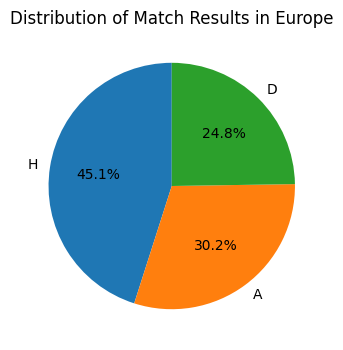

In [902]:
# Calculate value counts for 'result' column
result_counts = train['result'].value_counts()

# Plot pie chart
plt.figure(figsize=(4, 4))
plt.pie(result_counts, labels=result_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Match Results in Europe")
plt.show()




Test data is all data in the English division

In [903]:
#test=matches[(matches['competition'].str.contains("English")) &
#             (matches['gameweek']>25)]
test=matches[matches['competition'].str.contains("English")]


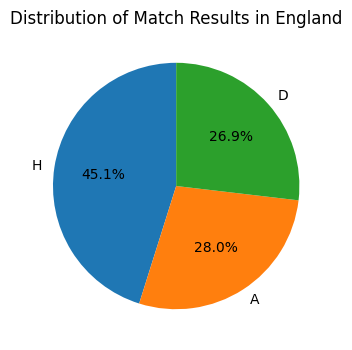

In [904]:
# Calculate value counts for 'result' column
result_counts = test['result'].value_counts()

# Plot pie chart
plt.figure(figsize=(4, 4))
plt.pie(result_counts, labels=result_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Match Results in England")
plt.show()


In [905]:
train=train.copy()
test=test.copy()
train.drop(columns=['competition','gameweek', 'result','dateutc'], inplace=True)
test.drop(columns=['competition','gameweek', 'result','dateutc'], inplace=True)

## Building my Model

In [906]:
# Step 1: Prepare data and label encode
# Step 2: Split the data
X_train = train.drop(columns=['label'])
y_train= train['label']

X_test= test.drop(columns=['label'])
y_test= test['label']

In [907]:
# Step 3 Scale the data

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [908]:
len(X_train[0])

52

### RandomForest

In [909]:
# Step 4: Train a model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [910]:
# Step 5: Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")

Model accuracy: 0.51


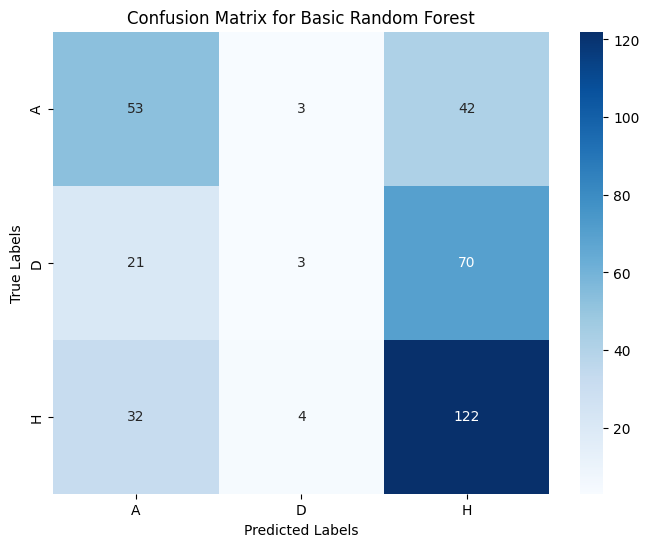

Classification Report:
               precision    recall  f1-score   support

           A       0.50      0.54      0.52        98
           D       0.30      0.03      0.06        94
           H       0.52      0.77      0.62       158

    accuracy                           0.51       350
   macro avg       0.44      0.45      0.40       350
weighted avg       0.46      0.51      0.44       350



In [911]:

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Basic Random Forest")
plt.show()

# Classification report
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", class_report)


In [912]:
#%%time
##Took 10 minutes to run with all the extra features
#param_grid = {
#    'n_estimators': [100, 200, 300],
#    'max_depth': [None, 10, 20, 30],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4],
#    'criterion': ['gini', 'entropy']
#}

#grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
#grid_search.fit(X_train, y_train)
#print(f'Best Parameters: {grid_search.best_params_}')

In [913]:
%%time
#Wall time: 1min 23s

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_iter=20, verbose=1)
random_search.fit(X_train, y_train)
print(f'Best Parameters: {random_search.best_params_}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'entropy'}
CPU times: user 2min 3s, sys: 311 ms, total: 2min 4s
Wall time: 2min 4s


In [914]:
model = RandomForestClassifier(
    criterion='entropy',
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=10,
    n_estimators=400,
    random_state=42
)

model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_split=10,
                       n_estimators=400, random_state=42)

In [915]:
# Step 5: Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")


Model accuracy: 0.52


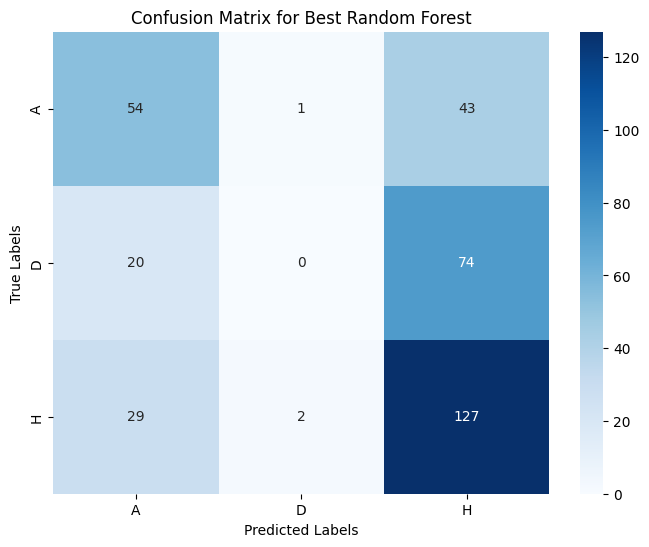

Classification Report:
               precision    recall  f1-score   support

           A       0.52      0.55      0.54        98
           D       0.00      0.00      0.00        94
           H       0.52      0.80      0.63       158

    accuracy                           0.52       350
   macro avg       0.35      0.45      0.39       350
weighted avg       0.38      0.52      0.44       350



In [916]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Best Random Forest")
plt.show()

# Classification report
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", class_report)

### XGBoost

In [917]:
# Train an XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [918]:
# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.48      0.50        98
           1       0.34      0.21      0.26        94
           2       0.54      0.70      0.61       158

    accuracy                           0.51       350
   macro avg       0.47      0.46      0.46       350
weighted avg       0.48      0.51      0.49       350



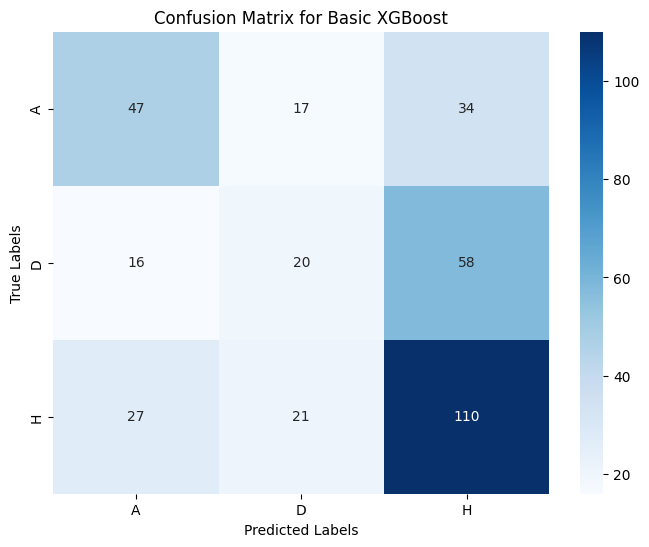

Classification Report:
               precision    recall  f1-score   support

           A       0.52      0.48      0.50        98
           D       0.34      0.21      0.26        94
           H       0.54      0.70      0.61       158

    accuracy                           0.51       350
   macro avg       0.47      0.46      0.46       350
weighted avg       0.48      0.51      0.49       350



In [919]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Basic XGBoost")
plt.show()

# Classification report
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", class_report)

In [920]:
uniform(0.5, 0.5)

In [921]:
%%time
# 1 minute
# Define the model
model = xgb.XGBClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': randint(100, 1000),          # Number of boosting rounds
    'learning_rate': uniform(0.01, 0.3),         # Learning rate
    'max_depth': randint(3, 10),                 # Max depth of tree
    'min_child_weight': randint(1, 10),          # Min child weight
    'subsample': uniform(0, 1),              # Fraction of samples used for each tree
    'colsample_bytree': uniform(0, 1),       # Fraction of features for each tree
    'gamma': uniform(0, 1),                      # Gamma (min loss reduction)
    'reg_alpha': uniform(0, 1),                  # L1 regularization term
    'reg_lambda': uniform(0, 1),                 # L2 regularization term
}

# Define the recall scorer for multiclass classification
#f1_scorer = make_scorer(f1_score, average='weighted')

# Initialize RandomizedSearchCV with the updated scorer
random_search = RandomizedSearchCV(model, param_distributions=param_grid, 
                                   n_iter=20, cv=5, scoring='accuracy',
                                   verbose=1, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_train, y_train)

# Output the best parameters
print(f'Best Parameters: {random_search.best_params_}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'colsample_bytree': 0.7722447692966574, 'gamma': 0.1987156815341724, 'learning_rate': 0.01165663513708072, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 692, 'reg_alpha': 0.71134195274865, 'reg_lambda': 0.7901755405312056, 'subsample': 0.6059599747810114}
CPU times: user 32.6 s, sys: 792 ms, total: 33.4 s
Wall time: 1min 2s


In [922]:
# Predict and evaluate
y_pred = random_search.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.54      0.52        98
           1       0.39      0.13      0.19        94
           2       0.53      0.72      0.61       158

    accuracy                           0.51       350
   macro avg       0.47      0.46      0.44       350
weighted avg       0.49      0.51      0.47       350



In [923]:
# Best hyperparameters from RandomizedSearchCV
best_params = {
    'colsample_bytree': 0.50,
    'gamma': 0.19,
    'learning_rate': 0.01,
    'max_depth': 10,
    'min_child_weight': 5,
    'n_estimators': 1000,
    'reg_alpha': 0.37,
    'reg_lambda': 0.79,
    'subsample': 0.60
}

model = xgb.XGBClassifier(**best_params)

In [924]:
#I like the params, they gave me these results

#              precision    recall  f1-score   support

#           0       0.51      0.58      0.54        98
#           1       0.48      0.14      0.21        94
#           2       0.54      0.72      0.62       158

#    accuracy                           0.53       350
#   macro avg       0.51      0.48      0.46       350
#weighted avg       0.52      0.53      0.49       350


## Best hyperparameters from RandomizedSearchCV
#best_params = {
#    'colsample_bytree': 0.50,
#    'gamma': 0.985,
#    'learning_rate': 0.01,
#    'max_depth': 6,
#    'min_child_weight': 7,
#    'n_estimators': 1000,
#    'reg_alpha': 0.37,
#    'reg_lambda': 0.24,
#    'subsample': 0.80
#}

#model = xgb.XGBClassifier(**best_params)

In [925]:
# Train the model
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.19, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [926]:
# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.52      0.53        98
           1       0.39      0.14      0.20        94
           2       0.54      0.75      0.63       158

    accuracy                           0.52       350
   macro avg       0.49      0.47      0.45       350
weighted avg       0.50      0.52      0.49       350



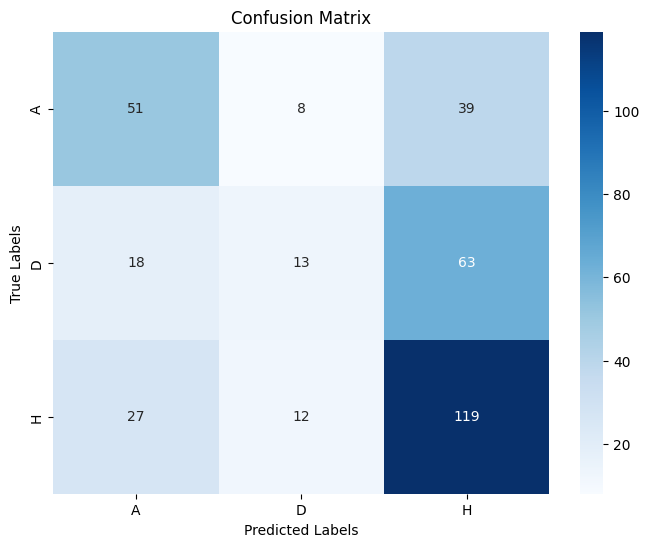

Classification Report:
               precision    recall  f1-score   support

           A       0.53      0.52      0.53        98
           D       0.39      0.14      0.20        94
           H       0.54      0.75      0.63       158

    accuracy                           0.52       350
   macro avg       0.49      0.47      0.45       350
weighted avg       0.50      0.52      0.49       350



In [927]:

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Classification report
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", class_report)

### Feature Importance

In [928]:
X_train

array([[ 2.26874937, -1.40453359, -1.36632368, ..., -0.46023798,
         1.28406093, -0.20777403],
       [-1.85731868, -1.40453359,  2.90113241, ..., -1.25065281,
        -0.72638069,  1.81286601],
       [-1.85731868, -1.40453359,  2.90113241, ..., -1.54185827,
        -1.07434174,  0.51384425],
       ...,
       [ 1.58107136, -0.38535804, -1.36632368, ...,  0.03897139,
         0.47215181,  0.78113868],
       [ 0.20571535,  0.29409232, -0.41800011, ...,  0.45497919,
        -0.03045859,  1.18561867],
       [-0.94041467,  0.97354269,  0.29324257, ...,  1.82780494,
         0.66546351,  0.56718455]])

In [929]:
train_features=train.drop(columns=['label'])

In [930]:
feature_importances = model.feature_importances_
features_df = pd.DataFrame({'feature': train_features.columns, 'importance': feature_importances})
features_df = features_df.sort_values(by='importance', ascending=False)
features_df

,feature,importance
44,away.avg_shot_count,0.025771
28,home.teams_player_rating,0.024472
29,away.GoalsPerGame,0.024064
51,away.teams_player_rating,0.023058
6,home.GoalsPerGame,0.023010
31,away.ConcededPerGame,0.022208
10,home.GoalsHTPerGame,0.021997
18,home.avg_pass_count,0.021632
41,away.avg_pass_count,0.021472
16,home.losses_last3,0.021163


In [931]:
#['home.ConcededPerGame_last3', 'away.ConcededHTPerGame', 'away.avg_concede_late_count', 'home.avg_launch_count', 'home.time_since_prev',
#'away.GoalsHTPerGame_last3', 'home.avg_concede_late_count', 'home.GoalsPerGame_last3', 'home.ConcededHTPerGame', 'home.GoalsHTPerGame_last3',
#'away.draws_away', 'away.time_since_prev', 'home.wins_last3', 'away.avg_shots_on_target_ratio', 'away.ConcededHTPerGame_last3',
#'away.GoalsPerGame_last3', 'away.draws_last3', 'home.draws_last3', 'away.ConcededPerGame_last3', 'home.draws_home']

The extra match level event features gave me a nice 1-2% accuracy improvement. I also got better F1 scores for the Away and Draw classes. 

In [932]:
len(features_df)

52

## PCA

In [933]:
pca_train = train.drop(columns=['label']).fillna(0)
y_train = train['label']

In [934]:
X_test = test.drop(columns=['label']).fillna(0)
y_test = test['label']

In [935]:
scaler = StandardScaler()
features_scaled_train = scaler.fit_transform(pca_train)
features_scaled_test = scaler.transform(X_test)

In [936]:

# Fit PCA on the training data and transform both train and test sets
pca = PCA(n_components=.95)  # Keeps components explaining 95% of the variance
features_pca_train = pca.fit_transform(features_scaled_train)
features_pca_test = pca.transform(features_scaled_test)

In [937]:

explained_variance = pca.explained_variance_ratio_
print(f'Explained variance by components: {explained_variance}')

Explained variance by components: [0.17282925 0.16033671 0.05752472 0.05189746 0.04850083 0.03728095
 0.03317367 0.0315684  0.03100467 0.02852669 0.02430134 0.02339037
 0.02299737 0.01983009 0.01900941 0.01758875 0.01681052 0.01585412
 0.015801   0.01501468 0.01439105 0.01366582 0.01295956 0.01136365
 0.0108011  0.00962412 0.00910268 0.00771263 0.00699164 0.00563931
 0.00548778]


In [938]:
 pca.explained_variance_ratio_.cumsum()

array([0.17282925, 0.33316596, 0.39069068, 0.44258814, 0.49108897,
       0.52836992, 0.56154359, 0.59311199, 0.62411666, 0.65264335,
       0.67694469, 0.70033505, 0.72333242, 0.74316251, 0.76217192,
       0.77976068, 0.79657119, 0.81242532, 0.82822631, 0.84324099,
       0.85763205, 0.87129787, 0.88425742, 0.89562107, 0.90642217,
       0.91604629, 0.92514897, 0.9328616 , 0.93985324, 0.94549255,
       0.95098033])

In [939]:
len(pca.explained_variance_ratio_)

31

<function matplotlib.pyplot.show(close=None, block=None)>

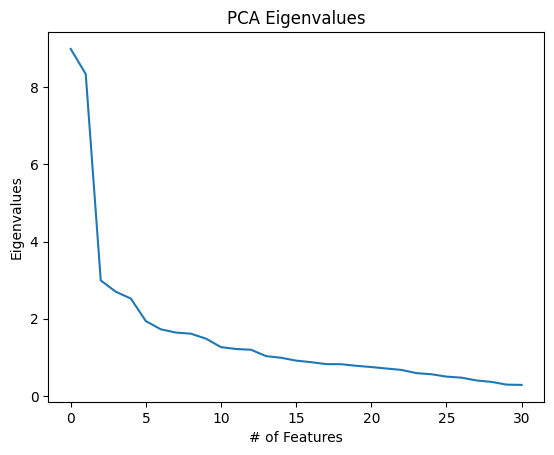

In [940]:
plt.title('PCA Eigenvalues')
plt.ylabel('Eigenvalues')
plt.xlabel('# of Features')
plt.plot(pca.explained_variance_)
plt.show

In [941]:
# Train an XGBoost model on the PCA-transformed training data
model = xgb.XGBClassifier()
model.fit(features_pca_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [942]:
# Predict and evaluate on PCA-transformed test data
y_pred = model.predict(features_pca_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.52      0.51        98
           1       0.36      0.22      0.28        94
           2       0.55      0.66      0.60       158

    accuracy                           0.51       350
   macro avg       0.47      0.47      0.46       350
weighted avg       0.49      0.51      0.49       350



#### finding least important features using PCA

In [957]:

# Standardize your data (important for PCA)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(pca_train)  # Assuming features_df is your data with 52 features

# Fit PCA to capture, say, 95% of the variance
pca = PCA(n_components=0.95)
pca.fit(features_scaled)

# Get the loadings (components), which are the coefficients for each feature in the principal components
loadings = pd.DataFrame(pca.components_.T, index=features_df.columns, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# Compute the absolute value of loadings and find the mean contribution of each feature across components
mean_loadings = loadings.abs().mean(axis=1)

mean_loadings.sort_values()

home.time_since_prev              0.048950
away.time_since_prev              0.050527
away.GoalsPerGame                 0.056573
home.GoalsPerGame                 0.069588
away.teams_player_rating          0.076286
home.teams_player_rating          0.080129
home.avg_pass_count               0.082612
away.avg_pass_count               0.087873
away.avg_accurate_pass_ratio      0.088022
away.wins_last3                   0.089195
away.ConcededPerGame              0.089858
home.losses_home                  0.090763
home.wins_last3                   0.092661
home.GoalsPerGame_last3           0.093881
home.avg_accurate_pass_ratio      0.094240
home.ConcededPerGame              0.094355
away.wins_away                    0.094536
home.GoalsHTPerGame               0.096909
away.GoalsHTPerGame               0.099432
away.GoalsPerGame_last3           0.099932
away.losses_away                  0.099983
home.ConcededPerGame_last3        0.101427
away.losses_last3                 0.102181
home.losses

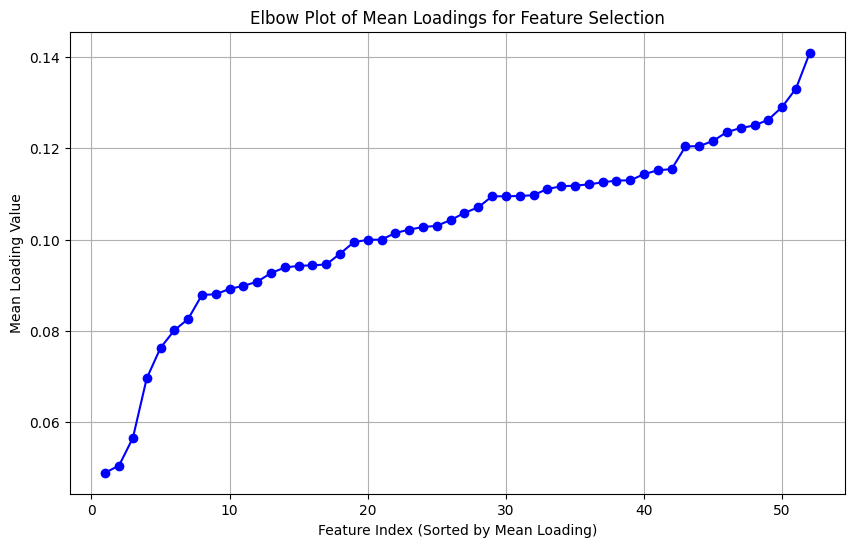

In [959]:
sorted_loadings = mean_loadings.sort_values()

# Plotting the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(sorted_loadings) + 1), sorted_loadings.values, marker='o', color='b')
plt.xlabel("Feature Index (Sorted by Mean Loading)")
plt.ylabel("Mean Loading Value")
plt.title("Elbow Plot of Mean Loadings for Feature Selection")
plt.grid(True)
plt.show()

In [963]:
# Sort features by their mean loading values in ascending order (lowest values indicate less important features)
least_important_features = mean_loadings.sort_values().head(7) 

print("Least important features according to PCA loadings:")
least_important_features


Least important features according to PCA loadings:


home.time_since_prev        0.048950
away.time_since_prev        0.050527
away.GoalsPerGame           0.056573
home.GoalsPerGame           0.069588
away.teams_player_rating    0.076286
home.teams_player_rating    0.080129
home.avg_pass_count         0.082612
dtype: float64

In [969]:
list(least_important_features.index)

['home.time_since_prev',
 'away.time_since_prev',
 'away.GoalsPerGame',
 'home.GoalsPerGame',
 'away.teams_player_rating',
 'home.teams_player_rating',
 'home.avg_pass_count']

Building a model with the 7 features which explain the least variance

In [995]:
pca_train = train.drop(columns=['label']).fillna(0)
pca_train.drop(columns=list(least_important_features.index),inplace=True)
y_train = train['label']


In [996]:
X_test = test.drop(columns=['label']).fillna(0)
X_test.drop(columns=list(least_important_features.index),inplace=True)
y_test = test['label']

In [998]:
scaler = StandardScaler()
features_scaled_train = scaler.fit_transform(pca_train)
features_scaled_test = scaler.transform(X_test)

In [1001]:
model = xgb.XGBClassifier()
model.fit(features_scaled_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [1002]:
# Predict and evaluate on PCA-transformed test data
y_pred = model.predict(features_scaled_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.47      0.49        98
           1       0.29      0.17      0.21        94
           2       0.51      0.66      0.58       158

    accuracy                           0.48       350
   macro avg       0.44      0.43      0.43       350
weighted avg       0.45      0.48      0.46       350



In [1004]:
%%time

# Define the model
model = xgb.XGBClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': randint(100, 1000),          # Number of boosting rounds
    'learning_rate': uniform(0.01, 0.3),         # Learning rate
    'max_depth': randint(3, 10),                 # Max depth of tree
    'min_child_weight': randint(1, 10),          # Min child weight
    'subsample': uniform(0, 1),              # Fraction of samples used for each tree
    'colsample_bytree': uniform(0, 1),       # Fraction of features for each tree
    'gamma': uniform(0, 1),                      # Gamma (min loss reduction)
    'reg_alpha': uniform(0, 1),                  # L1 regularization term
    'reg_lambda': uniform(0, 1),                 # L2 regularization term
}

# Define the recall scorer for multiclass classification
#f1_scorer = make_scorer(f1_score, average='weighted')

# Initialize RandomizedSearchCV with the updated scorer
random_search = RandomizedSearchCV(model, param_distributions=param_grid, 
                                   n_iter=20, cv=5, scoring='accuracy',
                                   verbose=1, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(features_scaled_train, y_train)

# Output the best parameters
print(f'Best Parameters: {random_search.best_params_}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'colsample_bytree': 0.363629602379294, 'gamma': 0.9717820827209607, 'learning_rate': 0.2987341884826334, 'max_depth': 8, 'min_child_weight': 7, 'n_estimators': 485, 'reg_alpha': 0.712270589924442, 'reg_lambda': 0.1480869299533999, 'subsample': 0.9977404850489419}
CPU times: user 4.44 s, sys: 547 ms, total: 4.99 s
Wall time: 41.6 s


In [1034]:
# Best hyperparameters from RandomizedSearchCV
best_params = {
    'colsample_bytree': 0.3,
    'gamma': 0.90,
    'learning_rate': 0.04,
    'max_depth': 3,
    'min_child_weight': 7,
    'n_estimators': 1000,
    'reg_alpha': 0.71,
    'reg_lambda': 0.15,
    'subsample': 0.30
}

model = xgb.XGBClassifier(**best_params)

model 
model.fit(features_scaled_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.9, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [1038]:
# Predict and evaluate
y_pred = model.predict(features_scaled_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.50      0.51      0.51        98
           1       0.44      0.24      0.32        94
           2       0.54      0.68      0.60       158

    accuracy                           0.51       350
   macro avg       0.49      0.48      0.47       350
weighted avg       0.50      0.51      0.50       350



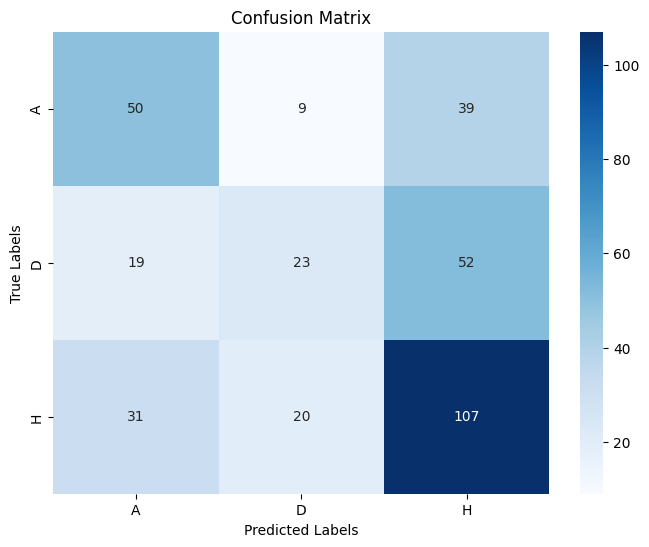

Classification Report:
               precision    recall  f1-score   support

           A       0.50      0.51      0.51        98
           D       0.44      0.24      0.32        94
           H       0.54      0.68      0.60       158

    accuracy                           0.51       350
   macro avg       0.49      0.48      0.47       350
weighted avg       0.50      0.51      0.50       350



In [1039]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Classification report
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", class_report)

## Highly Correlated Features

In [943]:
features_df=train.drop(columns=['label']).fillna(0)

corr_matrix=features_df.corr().abs()

In [944]:
# Define a style to highlight values over a threshold
def highlight_values(s):
    return ['background-color: red' if v > 0.8 else '' for v in s]

# Apply the style using `Styler.map` with axis=1 for row-wise application
corr_matrix.style.apply(highlight_values, axis=1)

,home.wins_home,home.draws_home,home.losses_home,away.wins_away,away.draws_away,away.losses_away,home.GoalsPerGame,home.GoalsPerGame_last3,home.ConcededPerGame,home.ConcededPerGame_last3,home.GoalsHTPerGame,home.GoalsHTPerGame_last3,home.ConcededHTPerGame,home.ConcededHTPerGame_last3,home.wins_last3,home.draws_last3,home.losses_last3,home.time_since_prev,home.avg_pass_count,home.avg_accurate_pass_ratio,home.avg_launch_count,home.avg_shot_count,home.avg_shots_on_target_ratio,home.avg_concede_late_count,home.num_started_prev,home.age,home.height,home.weight,home.teams_player_rating,away.GoalsPerGame,away.GoalsPerGame_last3,away.ConcededPerGame,away.ConcededPerGame_last3,away.GoalsHTPerGame,away.GoalsHTPerGame_last3,away.ConcededHTPerGame,away.ConcededHTPerGame_last3,away.wins_last3,away.draws_last3,away.losses_last3,away.time_since_prev,away.avg_pass_count,away.avg_accurate_pass_ratio,away.avg_launch_count,away.avg_shot_count,away.avg_shots_on_target_ratio,away.avg_concede_late_count,away.num_started_prev,away.age,away.height,away.weight,away.teams_player_rating
home.wins_home,1.000000,0.382915,0.761698,0.035815,0.048467,0.067428,0.701346,0.455911,0.541221,0.271381,0.563582,0.334141,0.391757,0.188926,0.489767,0.096676,0.391648,0.000531,0.545437,0.467629,0.376240,0.447720,0.389219,0.346312,0.137156,0.046312,0.028470,0.046045,0.585539,0.017859,0.018853,0.053696,0.049082,0.021839,0.031598,0.040641,0.054788,0.030923,0.026555,0.011885,0.011076,0.003524,0.009155,0.015527,0.023751,0.029802,0.064382,0.033483,0.008700,0.004703,0.007825,0.014087
home.draws_home,0.382915,1.000000,0.297113,0.027974,0.042725,0.056080,0.135841,0.086809,0.032511,0.029360,0.111651,0.046844,0.013923,0.016469,0.164005,0.341290,0.122146,0.005107,0.165808,0.118296,0.213653,0.133450,0.007316,0.000520,0.131192,0.107261,0.110188,0.099017,0.177881,0.001289,0.001881,0.048851,0.055904,0.023627,0.009188,0.004181,0.030694,0.005955,0.008487,0.002048,0.023236,0.005832,0.014948,0.029275,0.051525,0.006246,0.036061,0.008990,0.072438,0.026068,0.056203,0.002297
home.losses_home,0.761698,0.297113,1.000000,0.013303,0.016254,0.023819,0.636233,0.415372,0.585370,0.303001,0.506132,0.313784,0.394782,0.183664,0.392151,0.143405,0.494666,0.003836,0.447669,0.401344,0.243005,0.367635,0.405019,0.364382,0.050895,0.025530,0.045892,0.114040,0.478891,0.012302,0.014185,0.019062,0.010185,0.000234,0.035115,0.043904,0.034573,0.032039,0.036626,0.003955,0.025571,0.000794,0.019543,0.035522,0.014076,0.037018,0.040391,0.039501,0.041485,0.021315,0.031028,0.008463
away.wins_away,0.035815,0.027974,0.013303,1.000000,0.277681,0.739079,0.018925,0.042774,0.032991,0.056804,0.018799,0.047680,0.022412,0.038601,0.079815,0.034088,0.047857,0.003082,0.028412,0.018038,0.022367,0.028834,0.008301,0.017856,0.018873,0.039041,0.001435,0.029070,0.027450,0.701298,0.482822,0.652774,0.365588,0.612847,0.392009,0.507147,0.271586,0.533319,0.133959,0.442174,0.014562,0.561179,0.486240,0.410809,0.522767,0.428378,0.361153,0.112667,0.166589,0.042103,0.027594,0.628667
away.draws_away,0.048467,0.042725,0.016254,0.277681,1.000000,0.441899,0.005864,0.004209,0.063063,0.053537,0.007313,0.036864,0.070674,0.061329,0.016134,0.021831,0.030137,0.016406,0.030462,0.036554,0.034895,0.015992,0.028291,0.080908,0.040059,0.095613,0.036105,0.065912,0.012556,0.012761,0.008972,0.083935,0.032358,0.005944,0.023247,0.025323,0.017365,0.121119,0.331116,0.147525,0.001720,0.122478,0.105730,0.094698,0.029881,0.051749,0.028130,0.083422,0.058401,0.019938,0.005322,0.042007
away.losses_away,0.067428,0.056080,0.023819,0.739079,0.441899,1.000000,0.013560,0.036990,0.013413,0.015503,0.012426,0.018674,0.028629,0.006959,0.063217,0.047139,0.023556,0.008625,0.005170,0.008787,0.003582,0.015711,0.012086,0.040059,0.045712,0.030587,0.023976,0.019072,0.034437,0.663812,0.444562,0.668408,0.364071,0.576437,0.349753,0.491324,0.265780,0.413078,0.107087,0.516340,0.014804,0.438142,0.379907,0.317207,0.467201,0.436300,0.356964,0.046712,0.114609,0.053296,0.029499,0.557587
home.GoalsPerGame,0

In [945]:

# Step 2: Set a threshold for identifying highly correlated features
threshold = 0.8

# Step 3: Identify features to drop
# Select the upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than the threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

# Drop the identified features from the original dataset
features_df_reduced = features_df.drop(columns=to_drop)

print(f"Number of features reduced from {features_df.shape[1]} to {features_df_reduced.shape[1]}")

Number of features reduced from 52 to 45


In [946]:
to_drop

['home.GoalsHTPerGame',
 'home.avg_accurate_pass_ratio',
 'home.teams_player_rating',
 'away.GoalsHTPerGame',
 'away.time_since_prev',
 'away.avg_accurate_pass_ratio',
 'away.teams_player_rating']

## Train model with those columns omitted

In [950]:
train_sub=train.copy()
test_sub=test.copy()

In [951]:
train_sub.drop(columns=to_drop, inplace=True)
test_sub.drop(columns=to_drop, inplace=True)


In [952]:
# Step 1: Prepare data and label encode
# Step 2: Split the data
X_train = train_sub.drop(columns=['label'])
y_train= train_sub['label']

X_test= test_sub.drop(columns=['label'])
y_test= test_sub['label']

In [953]:
# Step 3 Scale the data

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [954]:
# Train an XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [955]:
# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.48      0.49        98
           1       0.40      0.18      0.25        94
           2       0.54      0.73      0.62       158

    accuracy                           0.51       350
   macro avg       0.48      0.46      0.45       350
weighted avg       0.49      0.51      0.49       350



I have added so many new features but am struggling to get the number above 51%-53%. This isnt far off what some models can predict. This paper says that some models perform around 54%, which is already better than bookmaker's accuracy at the time:
https://www.cambridge.org/core/journals/knowledge-engineering-review/article/artificial-intelligence-for-team-sports-a-survey/2E0E32861D031C022603F670B23B55B3

My data sources could be better (I will tap into more shortly). I only have 1 season's worth of data. And perhaps the other leagues (France, Germany, Italy, Spain) are not good predictors for England. 

Next I will build a model that learns iteratively. For every date in my model I will pass in the data, make predictions, but also let my model learn from that data.